# Chapter 2: End-to-End Machine Learning Project

##  Select a Performace Measure

1.A typical performace measure for regression problems is the Root Mean Square Error(RMSE).

## Check the Assumptions

1.It is good practice to list and verify the assumptions that were made so far(by you or others); this can catch serious issues early on.

## Take a Quick Look at the Data Structure

In [1]:
import pandas as pd

housing = pd.read_csv('../datasets/housing/housing.csv')
housing.head()  #take a loop at the top five rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [2]:
housing.info()  # get a quick description of the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
#find out what categories exist and how many districts belong to each category by using
# the value_counts() method:

housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
#The decribe() method shows a summary of the numerical attributes

housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

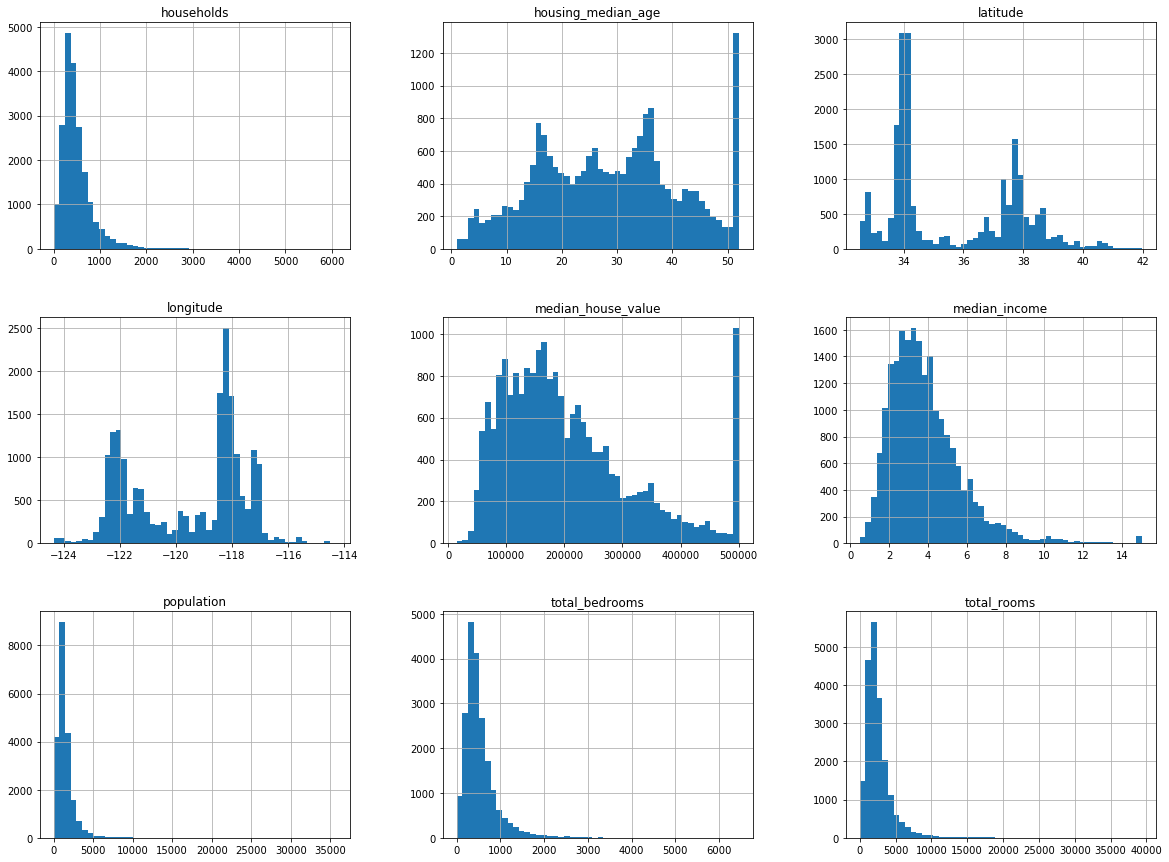

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

#hist() method will plot a histogram for each numerical attribute.

housing.hist(bins=50, figsize=(20,15))
plt.show()

### Notice a few things in these histograms:

1. The median income attribute does not look like it is expressed in US dollars. The data has been scaled and capped at 15(actually 15.0001) for higher median incomes, and at 0.5(actually 0.4999) for lower median incomes.

2. The housing median age and the median house value were also capped. so we need to check that if this is a problem or not.

3.  These attributes have very differents scales. so we should explore feature scaling

4.  Many histograms are tail heavy: This may make it a bit harder for some machine learning algorithms to detect patterns. we will try transforming these attributes later on to have more bell-shaped distributions

## Create a Test Set

Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside:

In [6]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))  
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]  #iloc 通过行号获取数据

trian_set, test_set = split_train_test(housing, 0.2)

#this works but not perfect: if we run the program again, it will generate a different test set!
#Over time, we will get to see the whole dataset.

#option 1. save the test set on the first run and then load it in subsequent runs.
#option 2. set the random number generator's seed before calling np.random.permutation().


In [7]:
len(trian_set)

16512

In [8]:
#Both the solutions will break next time we fetch an updated datasets.
#A comman solution is to use each instance's identifier to decide whether or not it should go 
#in the test set.

import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [9]:
train_set.head()

#if we use the row index as a unique identifier, we need to make sure that new data
#gets appended to the end of the dataset, and no row ever gets deleted.
#we should use more stable features to build a unique identifier.

index  longitude  latitude  housing_median_age  total_rooms  \
0      0    -122.23     37.88                41.0        880.0   
1      1    -122.22     37.86                21.0       7099.0   
2      2    -122.24     37.85                52.0       1467.0   
3      3    -122.25     37.85                52.0       1274.0   
6      6    -122.25     37.84                52.0       2535.0   

   total_bedrooms  population  households  median_income  median_house_value  \
0           129.0       322.0       126.0         8.3252            452600.0   
1          1106.0      2401.0      1138.0         8.3014            358500.0   
2           190.0       496.0       177.0         7.2574            352100.0   
3           235.0       558.0       219.0         5.6431            341300.0   
6           489.0      1094.0       514.0         3.6591            299200.0   

  ocean_proximity  
0        NEAR BAY  
1        NEAR BAY  
2        NEAR BAY  
3        NEAR BAY  
6        NEAR BAY

In [10]:
#we could combine the district's latitude and longitude into an ID

housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [11]:
#sklearn provides a few functions to split datasets into multiple subsets.
#The simplest function is train_test_split.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

* The following code creates an income category attribute by dividing the median income by 1.5(to limit the number of income categories), and rounding up using ceil(to have discrete categories), and then merging all the categories greater than 5 into category 5

In [12]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing.head(n=20)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0     -122.23     37.88                41.0        880.0           129.0   
1     -122.22     37.86                21.0       7099.0          1106.0   
2     -122.24     37.85                52.0       1467.0           190.0   
3     -122.25     37.85                52.0       1274.0           235.0   
4     -122.25     37.85                52.0       1627.0           280.0   
5     -122.25     37.85                52.0        919.0           213.0   
6     -122.25     37.84                52.0       2535.0           489.0   
7     -122.25     37.84                52.0       3104.0           687.0   
8     -122.26     37.84                42.0       2555.0           665.0   
9     -122.25     37.84                52.0       3549.0           707.0   
10    -122.26     37.85                52.0       2202.0           434.0   
11    -122.26     37.85                52.0       3503.0           752.0   
12    -122.26     37.85                52.0       2491.0           474.0   
13    -122.26     37.84                52.0        696.0           191.0   
14    -122.26     37.85                52.0       2643.0           626.0   
15    -122.26     37.85                50.0       1120.0           283.0   
16    -122.27     37.85                52.0       1966.0           347.0   
17    -122.27     37.85                52.0       1228.0           293.0   
18    -122.26     37.84                50.0       2239.0           455.0   
19    -122.27     37.84                52.0       1503.0           298.0   

    population  households  median_income  median_house_value ocean_proximity  \
0        322.0       126.0         8.3252            452600.0        NEAR BAY   
1       2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2        496.0       177.0         7.2574            352100.0        NEAR BAY   
3        558.0       219.0         5.6431            341300.0        NEAR BAY   
4        565.0       259.0         3.8462            342200.0        NEAR BAY   
5        413.0       193.0         4.0368            269700.0        NEAR BAY   
6       1094.0       514.0         3.6591            299200.0        NEAR BAY   
7       1157.0       647.0         3.1200            241400.0        NEAR BAY   
8       1206.0       595.0         2.0804            226700.0        NEAR BAY   
9       1551.0       714.0         3.6912            261100.0        NEAR BAY   
10       910.0       402.0         3.2031            281500.0        NEAR BAY   
11      1504.0       734.0         3.2705            241800.0        NEAR BAY   
12      1098.0       468.0         3.0750            213500.0        NEAR BAY   
13       345.0       174.0         2.6736            191300.0        NEAR BAY   
14      1212.0       620.0         1.9167            159200.0        NEAR BAY   
15       697.0       264.0         2.1250            140000.0        NEAR BAY   
16       793.0       331.0         2.7750            152500.0        NEAR BAY   
17       648.0       303.0         2.1202            155500.0        NEAR BAY   
18       990.0       419.0         1.9911            158700.0        NEAR BAY   
19       690.0       275.0         2.6033            162900.0        NEAR BAY   

    income_cat  
0          5.0  
1          5.0  
2          5.0  
3          4.0  
4          3.0  
5          3.0  
6          3.0  
7          3.0  
8          2.0  
9          3.0  
10         3.0  
11         3.0  
12         3.0  
13         2.0  
14         2.0  
15         2.0  
16         2.0  
17         2.0  
18         2.0  
19         2.0

In [13]:
#Now we are ready to do stratified sampling based on the income category.
#we can use sklearn StratifiedShuffleSplit class  分层抽样

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]     #loc 通过行标签索引数据

housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [14]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [15]:
#we should remove the income_cat attribute so the data is back to its original state:

for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

In [16]:
strat_train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   

      ocean_proximity  
17606       <1H OCEAN  
18632       <1H OCEAN  
14650      NEAR OCEAN  
3230           INLAND  
3555        <1H OCEAN

**we spent quite a bit of time on test set generation for a good reason:**

this is an often neglected but critical part of a Machine Learning project. 

These ideas will be useful later when we discuss cross-validation.

## Discover and Visualize the Data to Gain Insights

First, make sure we have put the test set aside and we are only exploring the trianing set.

create a copy so we can play with it without harming the training set:

In [17]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

create a scatterplot of all districts to visualize the data

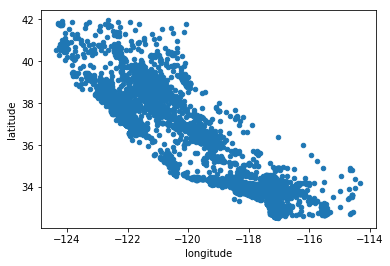

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude')

The plot is hard to see any particular pattern. Setting the aplha option to 0.1 makes it much easier to visualize the palces where there is high density of data points

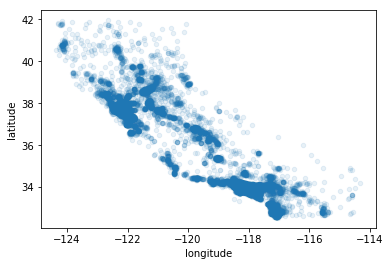

In [19]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Now we can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego,plus a long line of fairly high density in the Central Valley


**Now let's look at the housing prices**

cmap(in here called jet) is a predefined color map, which ranges from blue(low values) to red(high prices)

<function matplotlib.pyplot.legend>

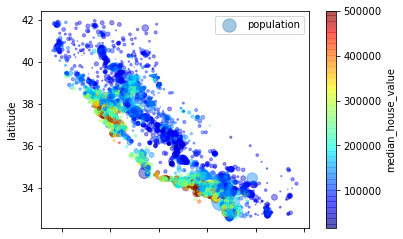

In [20]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population',
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,)
plt.legend

**The plot tells us that the housing prices are very much related to the location and to the population density.**

## Looking for Correlations

Since the dataset is not too large, we can compute the Pearson's r between every pair of attributes using corr()

In [21]:
corr_matrix = housing.corr()

#look at how much each attribute correlates with the median house value:

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1106ddeb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1141b4eb8>]], dtype=object)

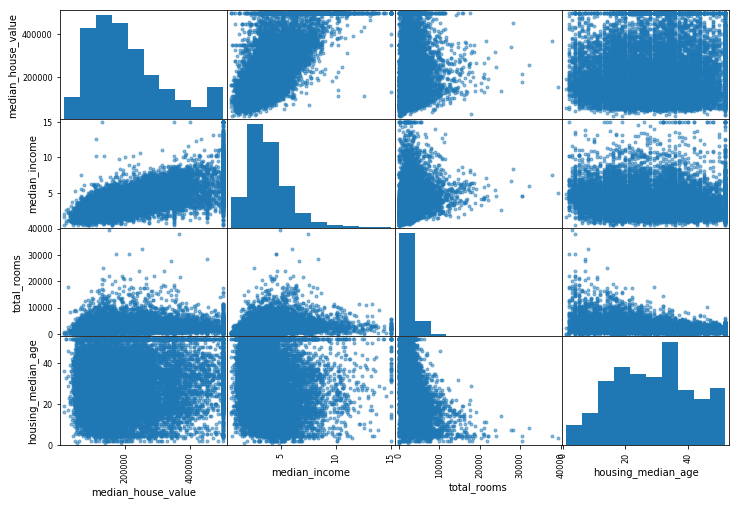

In [22]:
#Another way to check for correlation between attributes is to use Pandas' scatter_matrix function

from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

** Pandas displays a histogram of each attribute in the main diagonal**

The most promising attribute to predict the median house value is the median income.
so we zoom in on their correlation scatterplot

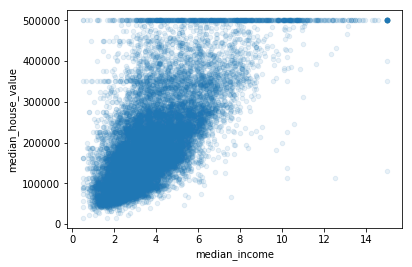

In [23]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

This plot reveals a few things

1. the correlation is indeed very strong
2. the price cap is clearly visible as a horizontal line. we may want to try to removing the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.


## Experimenting with Attribute Combinations

#### Insights about data:
1. There has a few data quirks that we may want to clean up before feeding the data to a ML algorithm.
2. There has a interesting correlations between attributes, in particular with the target attribute
3. There has some attributes have a tail-heavy distribution, so we may want to transform them(by computing their logarithm)


#### Attribute Combinations
1. The total number of rooms in a district is not very useful if we don't know how many households there are.
2. What we really want is the number of rooms per household.

In [24]:
#Let's create these new attributes:

housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [25]:
#look at the correlation matrix again
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

**The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms.**

## Prepare the Data for Machine Learning Algorithms

first revert to a clean training set, and let's separate the predictors and the labels

In [26]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

Most ML algorithms cannot work with missing features, so let's create a few functions to take care of them.

total_bedrooms attribute has some missing values, we should fix this. we have three options:
* Get rid of the corresponding districts.
* Get rid of the whole attribute.
* Set the values to some value(zero, the mean, the median, etc).

We can accomplish these using DataFrame's dropna(), drop(), and fillna() methods:

Sklearn provides a handy class to take care of missing values: Imputer.

1. create an Imputer instance
2. specifying that we want to replace each attribute's missing values with the median of that attribute

In [27]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [28]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [29]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling Text and Categorical Attributes

sklearn provides a transformer for this task called LabelEncoder

In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [31]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. To fix this issue, a common solution is to create one binary attribute per category. this is called one-hot encoding.

sklearn provides a OneHotEncoder encoder to convert integer categorical values into one-hot vectors.

In [32]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [33]:
#Use toarray() method can convert a sparse matrix to a numpy array
#housing_cat_1hot.toarray()

#We can apply both transformations in one shot using the LabelBinarizer class:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)

In [34]:
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Custom Transoformers

Although Sklearn provides many useful transformers, we will need to write our own for tasks.

**create a class and implement three methods:**
* fit()(returning self)
* transform()
* fit_transform()

**Example: a transformer class that adds the combined attrubuted we discussed earlier:**

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling

**One of the most important transformations we need to apply to our data is feature scaling**

ML algorithms don't perform well when the input numerical attributes have very different scales.

**Two way of scaling**
* *min-max scaling(normalization)*   

    Sklearn provides a transformer called MinMaxScaler for this.
    
 
* *standardization*

    Sklearn provides a transformer called StandardScaler for standardization


## Transformation Pipelines

Sklearn provides the Pipeline calass to help with a sequences of transformations.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', Imputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [38]:
#A full pipeline handling both numerical and categorical attributes 

from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                        ('imputer', Imputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),])

cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
                        ('label_binarizer', LabelBinarizer()),])

full_pipeline = FeatureUnion(transformer_list=[('num_pipeline', num_pipeline),
                                              ('cat_pipeline', cat_pipeline),])



In [39]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [40]:
housing_prepared.shape

(16512, 16)

## Select and Train a Model

### Traning and Evaluating on the Training Set

First train a Linear Regression model

In [41]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('Predictions:\t', lin_reg.predict(some_data_prepared))
print('Labels:\t\t', list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [43]:
#Measure this regression model's RMSE on the whole training set u
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

In [51]:
##########################################Excercises#######################################
#Exercises 1. Try a SVM regressor(sklearn.svm.SVR)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [{'kernel': ['linear'], 'C':[10., 30., 100., 300., 1000., 3000., 10000., 30000.]},
             {'kernel': ['rbf'], 'C':[1.0, 3.0, 10., 30., 100., 300., 1000.0],
             'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  17.0s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  17.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  17.1s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  17.4s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=  21.1s
[CV] C=30.0, ke

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.4min


[CV] ......................... C=10000.0, kernel=linear, total=  25.9s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  23.7s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=30000.0, kernel=linear, total=  38.2s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=30000.0, kernel=linear, total=  37.8s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ......................... C=30000.0, kernel=linear, total=  39.2s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ......................... C=30000.0, kernel=linear, total=  38.2s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ......................... C=30000.0, kernel=linear, total=  34.9s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] .

KeyboardInterrupt: 

In [50]:
svm_housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, svm_housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

118577.43356412371

Since the most districts' median_housing_values range between \$120,000 and \$265,000, so a typical prediction error of \$68,628 is not very satisfying. 

This is an example of a model underfitting the training data.

**Try a more complex model**

Train a DecisionTreeRegressor

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#evaluate the model on the training set

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Better Evaluation Using Cross-Validatioin

One way to evaluate the Decision Tree model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train our models against the smaller training set and evaluate them against the validation set.

A great alternative is to use *Skleran cross-validation feature*.

In [68]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [ 69635.19914153  67487.86856583  71416.42300552  68515.10895926
  70280.03464499  75139.85733975  71165.797687    70975.00312511
  76765.97193605  70302.512516  ]
Mean: 71168.3776921
Standard deviation: 2677.3145782


Now the DTree doesn't look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model!

Let's compute the same scores for the linear regression model


In [70]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


**The DTree model is overfitting so badly that it performs worse than the LR model**

Let's try one last model: the RandomForestRegressor.



In [71]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52491.57205258  50857.78924481  51037.02788053  54923.46534095
  50268.70195849  56289.62749287  52067.48740836  50490.57167747
  54123.84278881  51131.43905274]
Mean: 52368.1524898
Standard deviation: 1964.97385467


We should save every model we experiment with, so we can come back easily to any model we want. Using python's pickle module, or using sklearn.externals.joblib

In [73]:
#from sklearn.externals import joblib

#joblib.dump(my_model, 'my_model.pkl')

#later load model
#my_model_loaded = joblib.load('my_model.pkl')

## Fine-Tune our Model

### Grid Search

**One way to do that would be fiddle with the hyperparameters manually.**
**We should get Sklearn's GridSearchCV to search for us.**

The following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features':[2, 4, 6, 8]},
             {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [76]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [77]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [79]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63952.0562139 {'max_features': 2, 'n_estimators': 3}
55797.3586325 {'max_features': 2, 'n_estimators': 10}
52949.1872864 {'max_features': 2, 'n_estimators': 30}
60323.036976 {'max_features': 4, 'n_estimators': 3}
53117.7122003 {'max_features': 4, 'n_estimators': 10}
50638.9457892 {'max_features': 4, 'n_estimators': 30}
59593.1647818 {'max_features': 6, 'n_estimators': 3}
52106.4909585 {'max_features': 6, 'n_estimators': 10}
50093.2947573 {'max_features': 6, 'n_estimators': 30}
59635.8158851 {'max_features': 8, 'n_estimators': 3}
52042.9309939 {'max_features': 8, 'n_estimators': 10}
50117.2044431 {'max_features': 8, 'n_estimators': 30}
63029.8960447 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54614.7257887 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59464.5302195 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53111.8323329 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
59873.1119105 {'bootstrap': False, 'max_features': 4, 'n_estima

### Analyze the Best Models and Their Errors

In [81]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  8.46457402e-02,   6.73506947e-02,   4.31176156e-02,
         1.81838195e-02,   1.67736041e-02,   1.69654465e-02,
         1.62724113e-02,   3.23598652e-01,   6.20015706e-02,
         1.03862799e-01,   7.78990842e-02,   1.62544557e-02,
         1.42760005e-01,   6.61308740e-05,   4.64866837e-03,
         5.59930200e-03])

In [82]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32359865229211626, 'median_income'),
 (0.14276000532351543, 'INLAND'),
 (0.10386279880714784, 'pop_per_hhold'),
 (0.084645740183955556, 'longitude'),
 (0.077899084179726422, 'bedrooms_per_room'),
 (0.067350694673640063, 'latitude'),
 (0.062001570649716453, 'rooms_per_hhold'),
 (0.043117615556175527, 'housing_median_age'),
 (0.018183819520643366, 'total_rooms'),
 (0.01696544646069709, 'population'),
 (0.016773604082622344, 'total_bedrooms'),
 (0.016272411280930064, 'households'),
 (0.016254455743579619, '<1H OCEAN'),
 (0.0055993020021999785, 'NEAR OCEAN'),
 (0.0046486683692993115, 'NEAR BAY'),
 (6.6130874034703044e-05, 'ISLAND')]

### Evaluate Our System on the Test Set

In [83]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47917.292113593394